<a href="https://colab.research.google.com/github/narsym/deep-learning-with-pytorch/blob/master/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 96% 313M/325M [00:08<00:00, 36.9MB/s]
100% 325M/325M [00:08<00:00, 38.5MB/s]


In [ ]:
!unzip skin-cancer-malignant-vs-benign.zip

In [5]:
import os
os.listdir('.')

['.config',
 'skin-cancer-malignant-vs-benign.zip',
 'data',
 'train',
 'test',
 'kaggle.json',
 'sample_data']

In [6]:
import shutil
shutil.rmtree('./sample_data')

In [7]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transform
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline

In [8]:
torch.manual_seed(0)

In [9]:
class CancerData(Dataset):
  def __init__(self, data_dir, transform, data_type = 'train'):
    #path to the images
    path2data = os.path.join(data_dir, data_type)

    path1 = os.path.join(path2data, 'benign')
    path2 = os.path.join(path2data, 'malignant')

    #get a list of images
    filenames1 = os.listdir(path1)
    filenames2 = os.listdir(path2)
    self.full_filenames1 = [os.path.join(path1, f) for f in filenames1]
    self.full_filenames2 = [os.path.join(path2, f) for f in filenames2]

    self.full_filenames = self.full_filenames1 + self.full_filenames2

    self.labels = np.array([1] * len(self.full_filenames1) + [0] * len(self.full_filenames2))
    self.transform = transform
    
  def __len__(self):        
      # return size of dataset        
      return len(self.full_filenames)

  def __getitem__(self, idx):
      #open image, apply transforms and return with labels
      image = Image.open(self.full_filenames[idx])
      image = self.transform(image)
      return image, self.labels[idx]


In [10]:
import torchvision.transforms as transforms
data_transformer =  transforms.Compose([transforms.ToTensor()])

In [11]:
data_dir = './data'
dataset = CancerData(data_dir, data_transformer, 'train')
print(len(dataset))

2637


In [12]:
from torch.utils.data import random_split
len_data = len(dataset)
len_train = int(0.8 * len_data)
len_val = len_data - len_train
train_ds, val_ds = random_split(dataset, [len_train, len_val])
print(len(train_ds), len(val_ds))

2109 528


In [13]:
for x, y in train_ds:
  print(x.shape, y)
  break

torch.Size([3, 224, 224]) 1


In [14]:
for x, y in val_ds:
  print(x.shape, y)
  break

torch.Size([3, 224, 224]) 1


In [15]:
def show(img, y, color = True):
  # convert tensor to numpy array
  npimg = img.numpy()
  # convert to H*W*C shape
  npimg_tr = np.transpose(npimg, (1,2,0))
  if color == False:
    npimg_tr = npimg_tr[:,:,0]
    plt.imshow(npimg_tr, interpolation='nearest', cmap = 'gray')
  else:
    plt.imshow(npimg_tr, interpolation='nearest')
  plt.title('label:' + str(y))

In [16]:
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indicies:', rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow = 4, padding = 2)
print(x_grid_train.shape)

image indicies: [2105  603  271  770]
torch.Size([3, 228, 906])


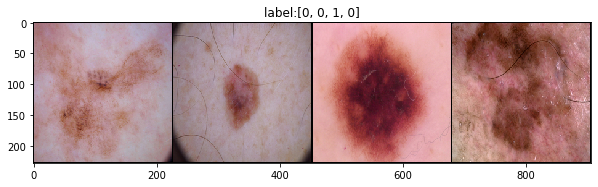

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

In [18]:
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print('image indicies:', rnd_inds)

x_grid_val = [val_ds[i][0] for i in rnd_inds]
y_grid_val = [val_ds[i][1] for i in rnd_inds]

x_grid_val = utils.make_grid(x_grid_val, nrow = 4, padding = 2)
print(x_grid_val.shape)

image indicies: [300 402 344 427]
torch.Size([3, 228, 906])


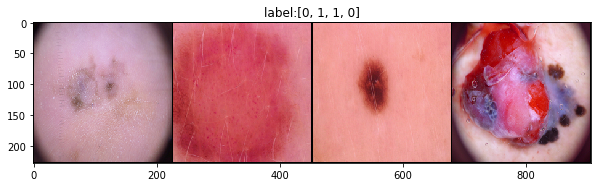

In [19]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_val, y_grid_val)

In [20]:
train_transformer = transforms.Compose([
  transforms.RandomHorizontalFlip(p = 0.5),
  transforms.RandomVerticalFlip(p = 0.5),
  transforms.RandomRotation(45),
  transforms.RandomResizedCrop(224, scale = (0.8, 1.0), ratio = (1.0, 1.0)), 
  transforms.ToTensor()
])

In [21]:
val_transformer = transforms.Compose([
  transforms.ToTensor()
])

In [22]:
train_ds.transform = train_transformer
val_ds.transform = val_transformer

In [23]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 32, shuffle = True)

In [24]:
for x, y in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [25]:
for x, y in val_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [26]:
y_val = [y for _, y in val_ds]
def accuracy(labels, out):
  return np.sum(out == labels) / float(len(labels))

acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print(f'accuracy all zero prediction: {acc_all_zeros}')

accuracy all zero prediction: 0.4564393939393939


In [27]:
acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print(f'accuracy all zero prediction: {acc_all_ones}')

accuracy all zero prediction: 0.5435606060606061


In [28]:
acc_random = accuracy(y_val, np.random.randint(2,size=len(y_val)))
print(f"accuracy random prediction: {acc_random}")

accuracy random prediction: 0.4753787878787879


In [29]:
import torch.nn as nn
import numpy as np

def findConv2dOutShape(H_in, W_in, conv, pool = 2):
  
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation
  H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)    
  W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)    
  
  if pool:        
    H_out/=pool        
    W_out/=pool    
  
  return int(H_out),int(W_out)

In [30]:
conv1 = nn.Conv2d(3, 8, kernel_size = 3)
h, w = findConv2dOutShape(224, 224, conv1)
print(h, w)

111 111


In [50]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [55]:
# dict to define model parameters
params_model={
        "input_shape": (3,224,224),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }

# create model
cnn_model = Net(params_model)

In [56]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

In [57]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [58]:
print(next(cnn_model.parameters()).device)

cuda:0


In [59]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
            Conv2d-2         [-1, 16, 109, 109]           1,168
            Conv2d-3           [-1, 32, 52, 52]           4,640
            Conv2d-4           [-1, 64, 24, 24]          18,496
            Linear-5                  [-1, 100]         921,700
            Linear-6                    [-1, 2]             202
Total params: 946,430
Trainable params: 946,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 5.40
Params size (MB): 3.61
Estimated Total Size (MB): 9.59
----------------------------------------------------------------


In [60]:
loss_func = nn.NLLLoss(reduction="sum")

In [61]:
# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [62]:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


In [63]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [64]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [65]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [66]:


for i in range(100):
    lr_scheduler.step(1)



Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


In [67]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [68]:
n,c=8,2
output = torch.randn(n, c, requires_grad=True)
print (output)
print(output.shape)

#target = torch.randint(c,size=(n,))
target = torch.ones(n,dtype=torch.long)
print(target.shape)

metrics_batch(output,target)

tensor([[ 0.4681, -0.1577],
        [ 1.4437,  0.2660],
        [ 0.1665,  0.8744],
        [-0.1435, -0.1116],
        [ 0.9318,  1.2590],
        [ 2.0050,  0.0537],
        [ 0.6181, -0.4128],
        [-0.8411, -2.3160]], requires_grad=True)
torch.Size([8, 2])
torch.Size([8])


3

In [69]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [70]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [71]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [73]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.010390, dev loss: 0.038565, accuracy: 4.92
----------
Epoch 1/99, current lr=0.0003
train loss: 0.010893, dev loss: 0.040737, accuracy: 4.36
----------
Epoch 2/99, current lr=0.0003
train loss: 0.010517, dev loss: 0.041813, accuracy: 3.60
----------
Epoch 3/99, current lr=0.0003
train loss: 0.010445, dev loss: 0.042279, accuracy: 2.65
----------
Epoch 4/99, current lr=0.0003
train loss: 0.010439, dev loss: 0.041471, accuracy: 3.41
----------
Epoch 5/99, current lr=0.0003
train loss: 0.010490, dev loss: 0.041955, accuracy: 2.65
----------
Epoch 6/99, current lr=0.0003
train loss: 0.010491, dev loss: 0.042475, accuracy: 2.84
----------
Epoch 7/99, current lr=0.0003
train loss: 0.010510, dev loss: 0.042272, accuracy: 2.84
----------
Epoch 8/99, current lr=0.0003
train loss: 0.010502, dev loss: 0.041795, accuracy: 3.03
----------
Epoch 9/99, current lr=0.0003
train loss: 0.010447, dev loss: 0.040280, accuracy: 3.98
----

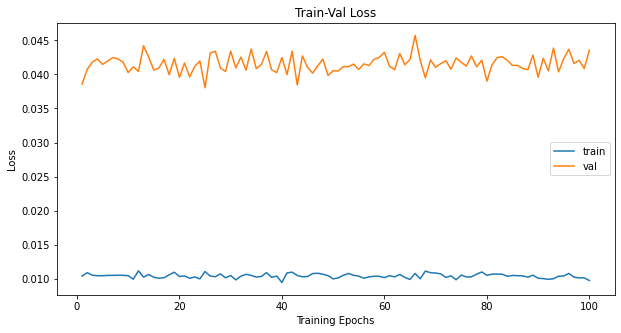

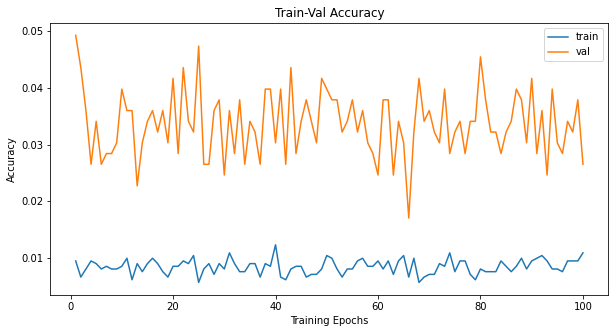

In [74]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [76]:


import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)



Epoch 0/1, current lr=0.0003
Copied best model weights!
train loss: 0.556908, dev loss: 0.497584, accuracy: 73.67
----------
Epoch 1/1, current lr=0.0003
Copied best model weights!
train loss: 0.516557, dev loss: 0.462447, accuracy: 76.52
----------


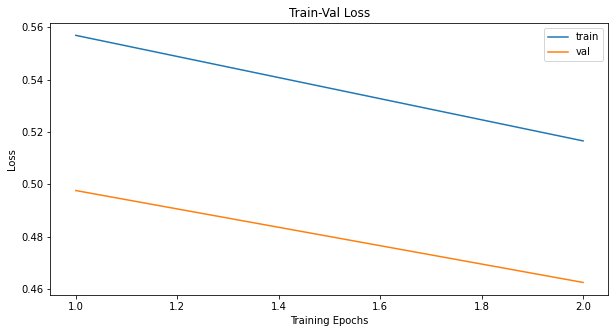

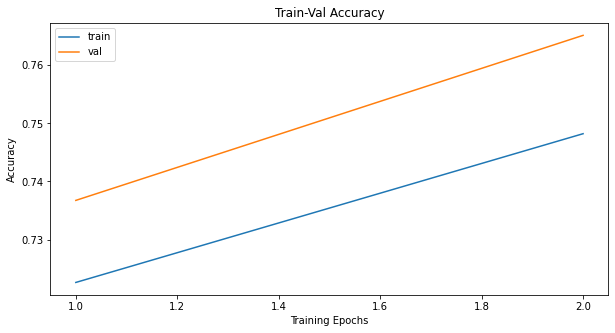

In [77]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()